# Sklearn bunch visualizer

A simple visualizer for sklearn Bunch datasets.

It visualizes:

* Best ratio for test/validation data by performing NearestNeighbors algorytm with minkowski's metric
* How samples are spreaded
* PCA

In [10]:
from multiprocessing import Process, Queue
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import *
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import Bunch

from samples import Samples, Sample

def nn(item: Sample, data: List[Sample]) -> Tuple[float, str]:
    nbps: NearestNeighbors = NearestNeighbors(n_neighbors=1).fit([sample.get_attributes() for sample in data])
    distance, sample_index = nbps.kneighbors([item.get_attributes()])
    return distance[0][0], data[sample_index[0][0]].get_class_name(),

def error_test(test_data: List[Sample], validation_data: List[Sample]) -> float:
    errors = 0
    for item in test_data:
        distance, class_name = nn(item, validation_data)
        if class_name != item.get_class_name():
            errors += 1
    try:
        return 100 * float(errors) / len(test_data)
    except ZeroDivisionError:
        return 0.0

def compute_errors(ratio: int, queue: Queue):
    test_data, validation_data = samples.get_test_data(ratio)
    return queue.put((ratio, error_test(test_data, validation_data)))

### Here you can choose which dataset you'd like to load.
This algorytm was tested with iris, digits, and diabetes data.

In [52]:
samples: Samples = Samples.load_from_bunch(load_iris())
#samples: Samples = Samples.load_from_bunch(load_diabetes())
#samples: Samples = Samples.load_from_bunch(load_digits())

In [53]:
samples.print_details()

print("Details of first sample: ")
print(samples.get_all_samples()[0])
for class_name in samples.get_classes():
    samples.print_class_details(class_name)

Has 3 classes, with total of 150 samples
Details of first sample: 
setosa - sepal length (cm): 5.1, sepal width (cm): 3.5, petal length (cm): 1.4, petal width (cm): 0.2
Class setosa has 50 samples
Class versicolor has 50 samples
Class virginica has 50 samples


## Visualization of best ratio for test/validation data

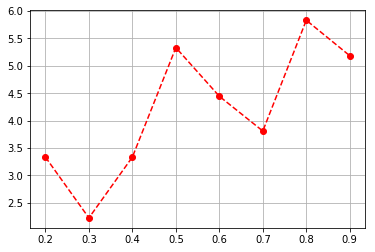

Best ration is 0.3 with error probability: 2.2222222222222223


In [54]:
output = Queue()
processes = [Process(target=compute_errors, args=(ratio, output,)) for ratio in np.linspace(0, 1, 11)[2:-1]]
for p in processes:
    p.start()
all_ratios = sorted([output.get() for p in processes], key=lambda k: k[0])
best_ratio = min(all_ratios, key=lambda ratio: ratio[1])
plt.plot([i[0] for i in all_ratios], [i[1] for i in all_ratios], 'ro--')
plt.grid(True)
plt.show()

print("Best ration is %s with error probability: %s" % (best_ratio[0], best_ratio[1]))


## Visualization of data spread

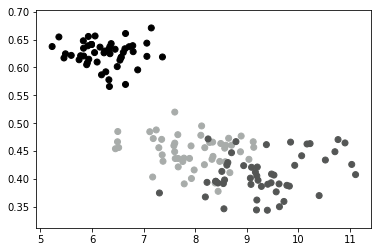

In [55]:
visual_data: List[Tuple[float, float, str]] = samples.get_visual_data()
x = list(zip(*visual_data))[0]
y = list(zip(*visual_data))[1]
colors = list(zip(*visual_data))[2]
plt.scatter(x, y, c=colors)
plt.show()
